In [ ]:
# download split folder library helper function
!pip -q install split-folders

In [ ]:
# [Optional] update Matplot to 3.5.X to get the new features 
# !pip install matplotlib -U

In [ ]:
!pip -q install ffmpeg-python 

In [ ]:
# !python -m pip show opencv-python

In [ ]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix
import splitfolders
import cv2
import random
import itertools
from collections import deque
# import ffmpeg
import os
import seaborn as sns

In [ ]:
# Mount the drive for dataset
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Prepare Arabic words dictionary

In [ ]:
# Arabic Dictionary 
!wget https://raw.githubusercontent.com/OSINTAI/Arabic_Words/master/Clean_tokens.txt
!unzip -q "/content/drive/MyDrive/ArASL_Database_54K_Final.zip"

--2022-09-09 10:26:31--  https://raw.githubusercontent.com/OSINTAI/Arabic_Words/master/Clean_tokens.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20956898 (20M) [text/plain]
Saving to: ‘Clean_tokens.txt’

Clean_tokens.txt    100%[===================>]  19.99M  --.-KB/s    in 0.1s    

2022-09-09 10:26:32 (154 MB/s) - ‘Clean_tokens.txt’ saved [20956898/20956898]



In [ ]:
df = pd.read_csv("Clean_tokens.txt", encoding="utf-16", names=["Words"])
df

,Words
0,ء
1,ءا
2,ءاء
3,ءاءة
4,ءاباءنا
...,...
1272528,يئيمها
1272529,يئين
1272530,يئيه
1272531,ييئوس


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272533 entries, 0 to 1272532
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Words   1272533 non-null  object
dtypes: object(1)
memory usage: 9.7+ MB


In [ ]:
words = np.array(df["Words"])
words[:5]

array(['ء', 'ءا', 'ءاء', 'ءاءة', 'ءاباءنا'], dtype=object)

In [ ]:
words[0]

'ء'

In [ ]:
one_word_index = np.where(df["Words"].map(lambda x: len(x) < 2))

In [ ]:
for i in one_word_index:
    print(df.iloc[i])

## EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


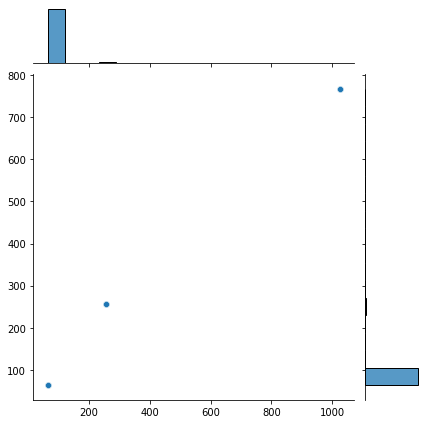

In [ ]:
# Check for image dimensions just to make sure
TRAIN_DIR = "/content/ArASL_Database_54K_Final"

dim1 = []
dim2 = []
for dirpath in os.listdir(TRAIN_DIR):
    label = TRAIN_DIR + "/" + dirpath
    images_list = os.listdir(label)
    for images in images_list:
        img = imread(label + "/" + images)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

sns.jointplot(dim1,dim2)
plt.show()

Good it seems the images some of them not standardized for certain dimensions. 

Let's see what most common dimensions are there.

In [ ]:
values, counts = np.unique(dim1, return_counts=True)
values, counts

(array([  64,  256, 1024]), array([53401,   638,    10]))

In [ ]:
values_2, counts_2 = np.unique(dim2, return_counts=True)
values_2, counts_2

(array([ 64, 256, 768]), array([53401,   638,    10]))

Nice! we can clearly see that those dimensions have a kind of standard size. 

For Height it goes with [64, 256, 1024]

For Width it goes with [64, 256, 768]

And each of them having this number of [53401,   638,    10] samples respectively.

For This Experiment we'll reshape all images to 64 * 64 since it's the majority and the minimum value. Since it's bad to stretch the pixels for 256 or even 1000 for height & width.

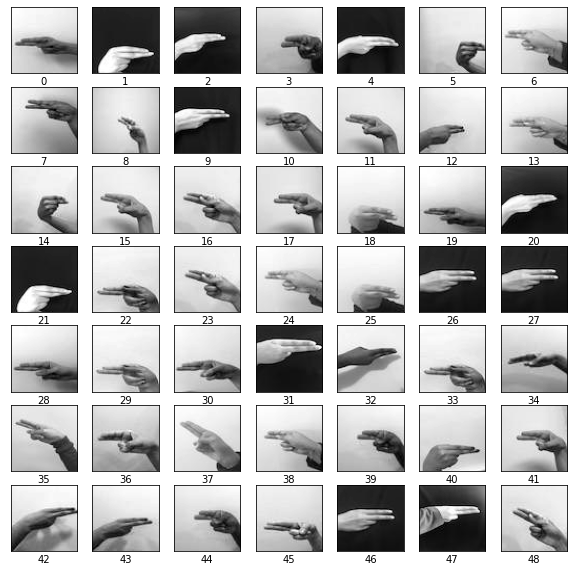

In [ ]:
# Visualizing One Class
plt.figure(figsize=(10, 10))
for i, img_name in enumerate(os.listdir("/content/ArASL_Database_54K_Final/ain")[:49]):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = TRAIN_DIR + "/ain/" + img_name
    img = imread(path)
    plt.imshow(img, cmap='gray')
    plt.xlabel(i)

Great! Also the authors of this dataset said on the description for those collected images are in grayscale. That's why i parsed it as cmap="gray".

In [ ]:
# How many images for each class ?
label_count = {}
for dirpath, dirnames, filenames in os.walk("/content/ArASL_Database_54K_Final"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
    if len(dirnames) == 0:
        # Count the images inside the directory
        label_count[dirpath.split('/')[-1]] = len(filenames)

There are 32 directories and 0 images in /content/ArASL_Database_54K_Final
There are 0 directories and 1670 images in /content/ArASL_Database_54K_Final/dhad
There are 0 directories and 1977 images in /content/ArASL_Database_54K_Final/ghain
There are 0 directories and 1746 images in /content/ArASL_Database_54K_Final/la
There are 0 directories and 1659 images in /content/ArASL_Database_54K_Final/ra
There are 0 directories and 1638 images in /content/ArASL_Database_54K_Final/seen
There are 0 directories and 1582 images in /content/ArASL_Database_54K_Final/thal
There are 0 directories and 1371 images in /content/ArASL_Database_54K_Final/waw
There are 0 directories and 1343 images in /content/ArASL_Database_54K_Final/al
There are 0 directories and 2114 images in /content/ArASL_Database_54K_Final/ain
There are 0 directories and 1526 images in /content/ArASL_Database_54K_Final/haa
There are 0 directories and 1507 images in /content/ArASL_Database_54K_Final/sheen
There are 0 directories and 18

In [ ]:
# Dict for label counts
label_count

{'dhad': 1670,
 'ghain': 1977,
 'la': 1746,
 'ra': 1659,
 'seen': 1638,
 'thal': 1582,
 'waw': 1371,
 'al': 1343,
 'ain': 2114,
 'haa': 1526,
 'sheen': 1507,
 'saad': 1895,
 'ta': 1816,
 'gaaf': 1705,
 'fa': 1955,
 'thaa': 1766,
 'aleff': 1672,
 'zay': 1374,
 'ya': 1722,
 'nun': 1819,
 'ha': 1592,
 'dal': 1634,
 'meem': 1765,
 'jeem': 1552,
 'khaa': 1607,
 'taa': 1838,
 'yaa': 1293,
 'laam': 1832,
 'bb': 1791,
 'kaaf': 1774,
 'toot': 1791,
 'dha': 1723}

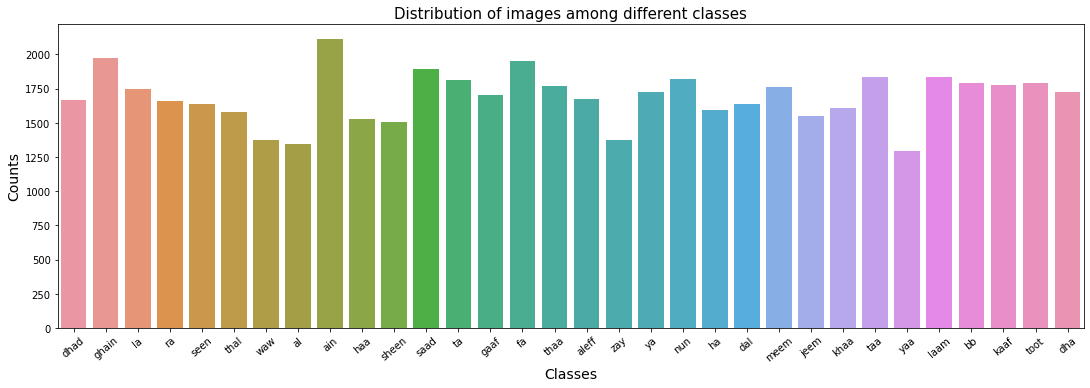

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x=list(label_count.keys()), y=list(label_count.values()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
plt.tight_layout()
plt.title('Distribution of images among different classes', fontsize=15)
plt.xlabel('Classes', fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

Beautiful Barplot! now we can see that it's not class balanced we see different peaks for certain classes, Like class "Ain" & "Ghain" & "Fa.
But Overall it's great we can experiment with it. 

Enough with EDA we can start preparing data & data loaders and start with training the model!

## Split Data into train/val/test subfolders

In [ ]:
# Splitting train/val/test as .6/.2/.2 respectively
splitfolders.ratio("ArASL_Database_54K_Final", "ArASL_Database_54K_splitted", seed=1337, ratio=(0.6, 0.2, 0.2))

Copying files: 54049 files [00:06, 8005.64 files/s]


## Data loaders using ImageDataGenerator

In [ ]:
def grayscale_to_rgb(image):
    image = tf.expand_dims(image, axis=-1)
    image = tf.convert_to_tensor(image)
    return tf.image.grayscale_to_rgb(image)

In [ ]:
TRAIN_DIR = "/content/ArASL_Database_54K_splitted/train"
VAL_DIR = "/content/ArASL_Database_54K_splitted/val"
TEST_DIR = "/content/ArASL_Database_54K_splitted/test"
IMAGE_SIZE = 64

train_gen = ImageDataGenerator(rescale=1/255.,
                               shear_range=0.1,
                               zoom_range=0.1,
                               width_shift_range=0.2,
	                           height_shift_range=0.2,
                               brightness_range=(0.1, 0.4),)
                            #    preprocessing_function=grayscale_to_rgb)

val_gen = ImageDataGenerator(rescale=1/255.,)
                            #  preprocessing_function=grayscale_to_rgb)

test_gen = ImageDataGenerator(rescale=1/255.,)
                            #   preprocessing_function=grayscale_to_rgb)

train_data = train_gen.flow_from_directory(directory=TRAIN_DIR,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           batch_size=32,
                                           class_mode="categorical",
                                           color_mode="rgb",
                                           shuffle=True,
                                           seed=1337)

val_data = val_gen.flow_from_directory(directory=VAL_DIR,
                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                       batch_size=32,
                                       class_mode="categorical",
                                       color_mode="rgb",
                                       shuffle=False,
                                       seed=1337)

test_data = test_gen.flow_from_directory(directory=TEST_DIR,
                                         target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                         shuffle=False,
                                         batch_size=32,
                                         class_mode="categorical",
                                         color_mode="rgb",
                                         seed=1337)

Found 10835 images belonging to 32 classes.


In [ ]:
train_gen.flow_from_directory??

In [ ]:
img, lbl =  test_data.next()
img.shape

(16, 64, 64, 3)

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

## Creating First CNN model

In [ ]:
# base_model = ResNet50(include_top=False)
# base_model.trianable = False
IMAGE_SHAPE = (64, 64, 3)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, activation="relu", input_shape=IMAGE_SHAPE),
    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    # tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="softmax")
], name="Model_1")

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.1, 
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-6)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=3,
                                              restore_best_weights=True)

model_1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 global_average_pooling2d_1   (None, 64)               0         
 (GlobalAveragePooling2D)                                  

### Train the model

In [ ]:
model_1.fit(train_data,
            epochs=500,
            steps_per_epoch=len(train_data),
            validation_data=val_data,
            validation_steps=len(val_data),
            callbacks=[early_stop])

Epoch 1/500
1014/1014 [==============================] - 72s 71ms/step - loss: 2.9270 - accuracy: 0.1488 - val_loss: 3.7189 - val_accuracy: 0.2011
Epoch 2/500
1014/1014 [==============================] - 72s 71ms/step - loss: 2.1168 - accuracy: 0.3640 - val_loss: 2.5284 - val_accuracy: 0.4585
Epoch 3/500
1014/1014 [==============================] - 71s 70ms/step - loss: 1.6235 - accuracy: 0.5158 - val_loss: 1.9674 - val_accuracy: 0.5699
Epoch 4/500
1014/1014 [==============================] - 71s 70ms/step - loss: 1.3665 - accuracy: 0.5866 - val_loss: 2.1733 - val_accuracy: 0.5584
Epoch 5/500
1014/1014 [==============================] - 71s 70ms/step - loss: 1.2433 - accuracy: 0.6311 - val_loss: 2.0352 - val_accuracy: 0.6179
Epoch 6/500
1014/1014 [==============================] - 71s 70ms/step - loss: 1.0812 - accuracy: 0.6756 - val_loss: 1.3019 - val_accuracy: 0.7184
Epoch 7/500
1014/1014 [==============================] - 71s 70ms/step - loss: 0.9872 - accuracy: 0.7053 - val_loss: 1

## Creating Second CNN Model

In [ ]:
TRAIN_DIR = "/content/ArASL_Database_54K_splitted/train"
VAL_DIR = "/content/ArASL_Database_54K_splitted/val"
IMAGE_SIZE = 64

train_gen = ImageDataGenerator(rescale=1/255.,
                               shear_range=0.1,
                               zoom_range=0.1,
                               width_shift_range=0.2,
	                           height_shift_range=0.2,
                               brightness_range=(0.1, 0.4),)
                            #    preprocessing_function=grayscale_to_rgb)

val_gen = ImageDataGenerator(rescale=1/255.,)
                            #  preprocessing_function=grayscale_to_rgb)

train_data = train_gen.flow_from_directory(directory=TRAIN_DIR,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           batch_size=16,
                                           class_mode="sparse",
                                           color_mode="rgb",
                                           shuffle=True,
                                           seed=1337)

val_data = val_gen.flow_from_directory(directory=VAL_DIR,
                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                       batch_size=16,
                                       class_mode="sparse",
                                       color_mode="rgb",
                                       shuffle=False,
                                       seed=1337)

IMAGE_SHAPE = (64, 64, 3)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, activation="relu", input_shape=IMAGE_SHAPE),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(32, activation="softmax")
], name="Model_1")

model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=3,
                                              restore_best_weights=True)

model_2.summary()

Found 32417 images belonging to 32 classes.
Found 10797 images belonging to 32 classes.
Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 12, 128)       73856     
                                     

### Train 2nd CNN model

In [ ]:
hist_2 = model_2.fit(train_data,
                    epochs=500,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data),
                    callbacks=[early_stop])

Epoch 1/500
2027/2027 [==============================] - 69s 33ms/step - loss: 3.4284 - accuracy: 0.0429 - val_loss: 3.2429 - val_accuracy: 0.1087
Epoch 2/500
2027/2027 [==============================] - 69s 34ms/step - loss: 2.0132 - accuracy: 0.3970 - val_loss: 1.6997 - val_accuracy: 0.6337
Epoch 3/500
2027/2027 [==============================] - 67s 33ms/step - loss: 1.0904 - accuracy: 0.6572 - val_loss: 1.0846 - val_accuracy: 0.7638
Epoch 4/500
2027/2027 [==============================] - 67s 33ms/step - loss: 0.8223 - accuracy: 0.7449 - val_loss: 0.8412 - val_accuracy: 0.8176
Epoch 5/500
2027/2027 [==============================] - 67s 33ms/step - loss: 0.6585 - accuracy: 0.7973 - val_loss: 0.7084 - val_accuracy: 0.8545
Epoch 6/500
2027/2027 [==============================] - 67s 33ms/step - loss: 0.5582 - accuracy: 0.8279 - val_loss: 0.5636 - val_accuracy: 0.8758
Epoch 7/500
2027/2027 [==============================] - 67s 33ms/step - loss: 0.4781 - accuracy: 0.8542 - val_loss: 0

### Evaluate on Test data

In [ ]:
model_2.evaluate(test_data)

339/339 [==============================] - 4s 13ms/step - loss: 0.2545 - accuracy: 0.9455


[0.2544999122619629, 0.9455468654632568]

In [ ]:
model_2.save("Arabic-sign-language-translation-CNN.h5")

In [ ]:
model_2 = tf.keras.models.load_model("/content/drive/MyDrive/Arabic-sign-language-translation-CNN.h5")
# model_2.evaluate(test_data)

In [ ]:
preds_2 = pd.DataFrame(hist_2.history)
preds_2[["loss", "val_loss"]].plot()
preds_2[["accuracy", "val_accuracy"]].plot()

In [ ]:
probs = model_2.predict(test_data)
y_preds = probs.argmax(axis=1)
y_preds

array([ 0,  0,  0, ..., 31, 31, 31])

In [ ]:
class_names = sorted(os.listdir("/content/ArASL_Database_54K_Final/"))
class_names

['ain',
 'al',
 'aleff',
 'bb',
 'dal',
 'dha',
 'dhad',
 'fa',
 'gaaf',
 'ghain',
 'ha',
 'haa',
 'jeem',
 'kaaf',
 'khaa',
 'la',
 'laam',
 'meem',
 'nun',
 'ra',
 'saad',
 'seen',
 'sheen',
 'ta',
 'taa',
 'thaa',
 'thal',
 'toot',
 'waw',
 'ya',
 'yaa',
 'zay']

### Plotting Confusion Matrix

In [ ]:
# Function to Plot confusion matrix
# Special Thanks to mrdbourke for this awesome function, 
# credits:https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/02_neural_network_classification_in_tensorflow.ipynb
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.magma_r) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set_title('Confusion Matrix', fontsize=80, color="white")
  ax.set_xlabel('Predicted label', fontsize=80)
  ax.set_ylabel('True label', fontsize=80)
  fig.patch.set_facecolor('black')
  ax.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
  ax.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
  ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
  ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
  # Label the axes
  ax.set(
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
#   ax.xaxis.get_label().set_fontsize(9)
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)


  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)


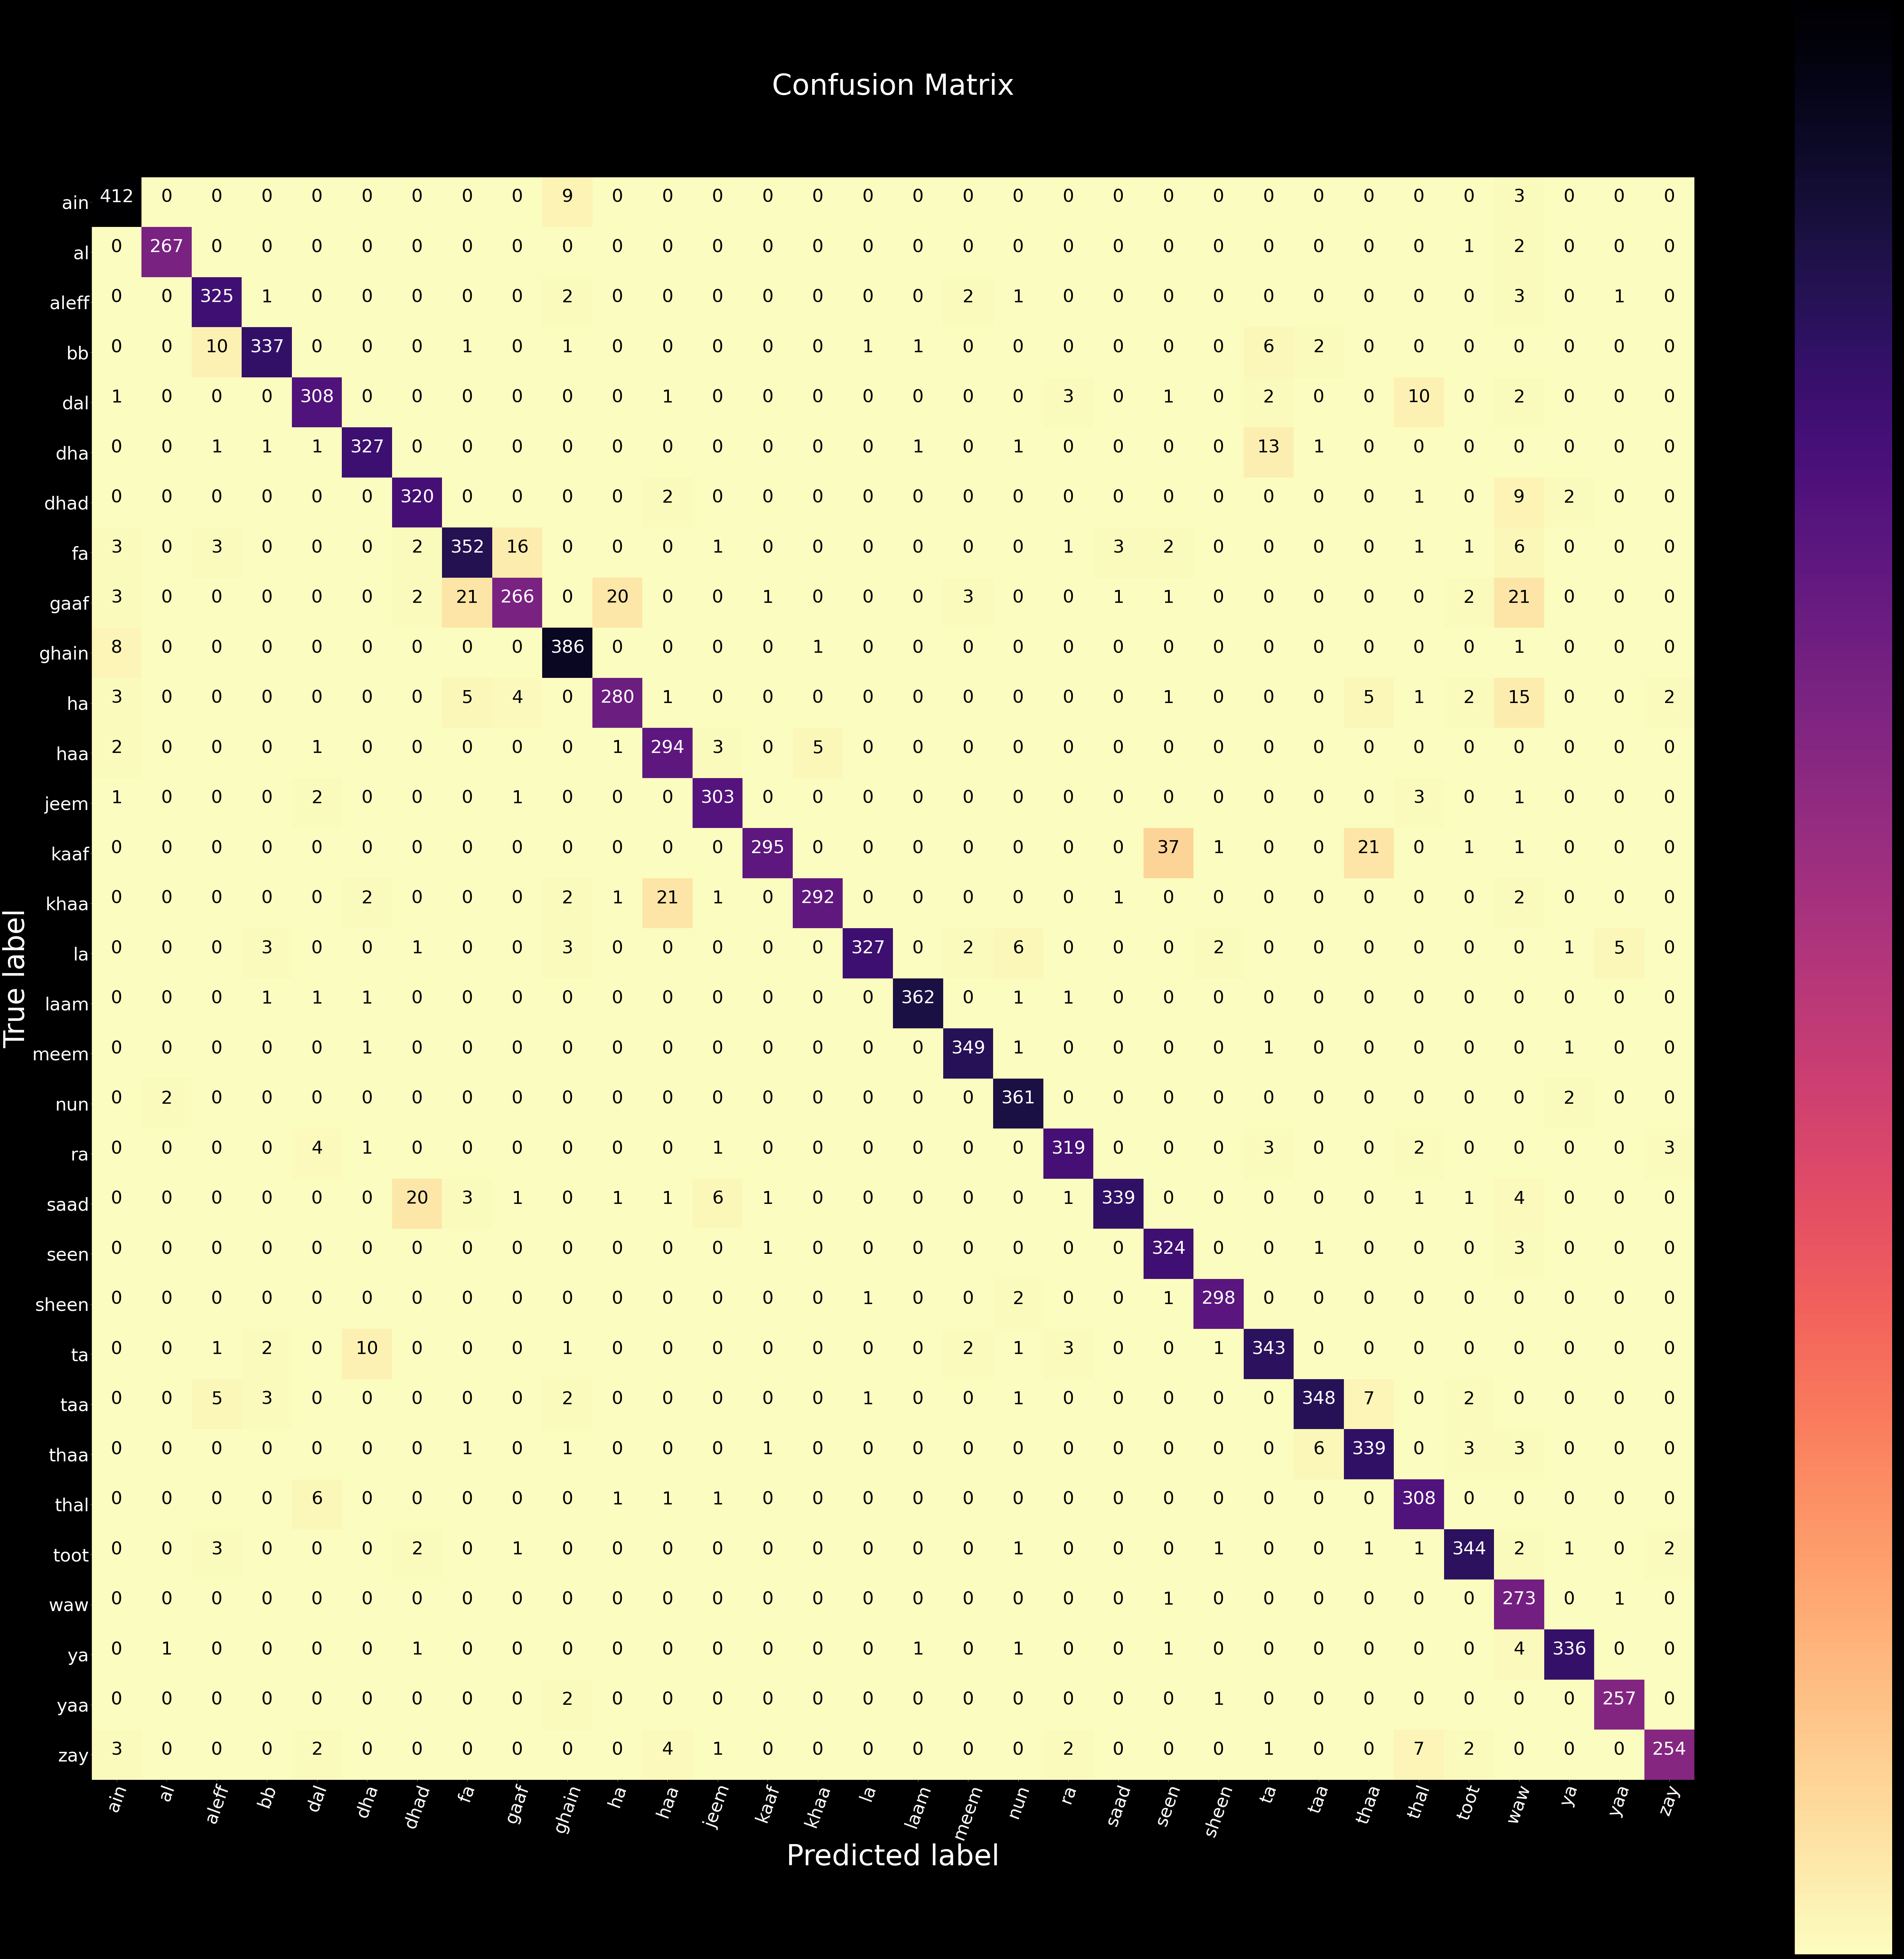

In [ ]:
# Plot a confusion matrix
make_confusion_matrix(y_true=test_data.classes,
                      y_pred=y_preds,
                      figsize=(100, 100),
                      classes=class_names,
                      text_size=50,
                      norm=False)

### Testing Model Predictions on test data

In [ ]:
def prepare_image(image_path, image_shape=64):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, size=[image_shape, image_shape])
    image = tf.cast(image, dtype=tf.float32)
    return image/255.

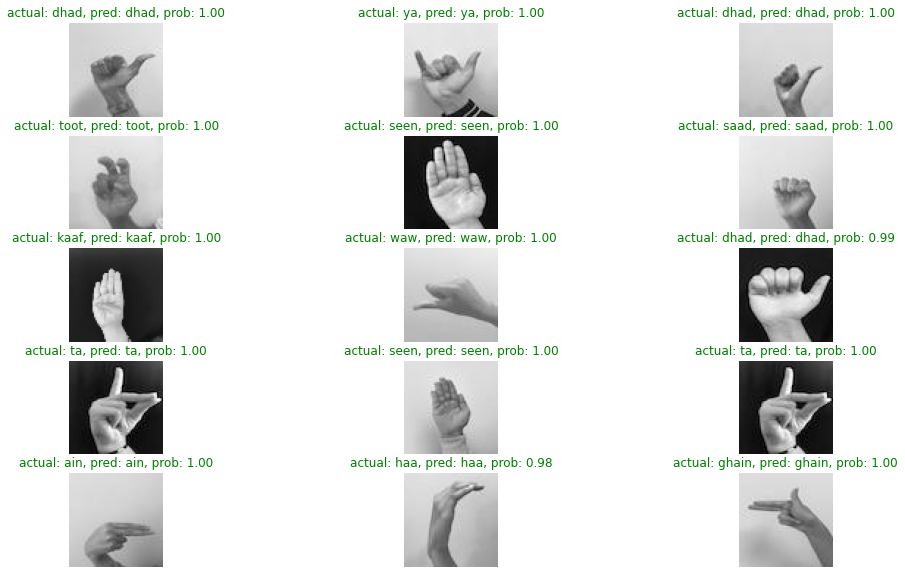

In [ ]:
plt.figure(figsize=(17, 10))
for i in range(15):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(TEST_DIR + "/" + class_name))
  filepath = TEST_DIR + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = prepare_image(filepath) 
  pred_prob = model_2.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
  plt.subplot(5, 3, i+1)
  plt.imshow(img)
  if class_name == pred_class: 
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Plotting F1 scores

In [ ]:
# Prepare dictionary for F1 scores
from sklearn.metrics import classification_report
classification_dictionary = classification_report(test_data.classes, y_preds, output_dict=True)
classes_f1_score = {}

for k, v in classification_dictionary.items():
    if k == "accuracy":
        break
    classes_f1_score[class_names[int(k)]] = v["f1-score"]
classes_f1_score

{'ain': 0.958139534883721,
 'al': 0.9888888888888889,
 'aleff': 0.9516837481698389,
 'bb': 0.9533239038189533,
 'dal': 0.9433384379785605,
 'dha': 0.9505813953488372,
 'dhad': 0.93841642228739,
 'fa': 0.9095607235142118,
 'gaaf': 0.8444444444444444,
 'ghain': 0.9590062111801242,
 'ha': 0.898876404494382,
 'haa': 0.9318541996830427,
 'jeem': 0.9649681528662422,
 'kaaf': 0.900763358778626,
 'khaa': 0.9419354838709677,
 'la': 0.9617647058823529,
 'laam': 0.9890710382513661,
 'meem': 0.9817158931082982,
 'nun': 0.9730458221024257,
 'ra': 0.9622926093514329,
 'saad': 0.937759336099585,
 'seen': 0.9283667621776505,
 'sheen': 0.9834983498349835,
 'ta': 0.9358799454297406,
 'taa': 0.9573590096286108,
 'thaa': 0.9325997248968363,
 'thal': 0.9447852760736196,
 'toot': 0.958217270194986,
 'waw': 0.8666666666666667,
 'ya': 0.9767441860465117,
 'yaa': 0.9809160305343512,
 'zay': 0.9459962756052142}

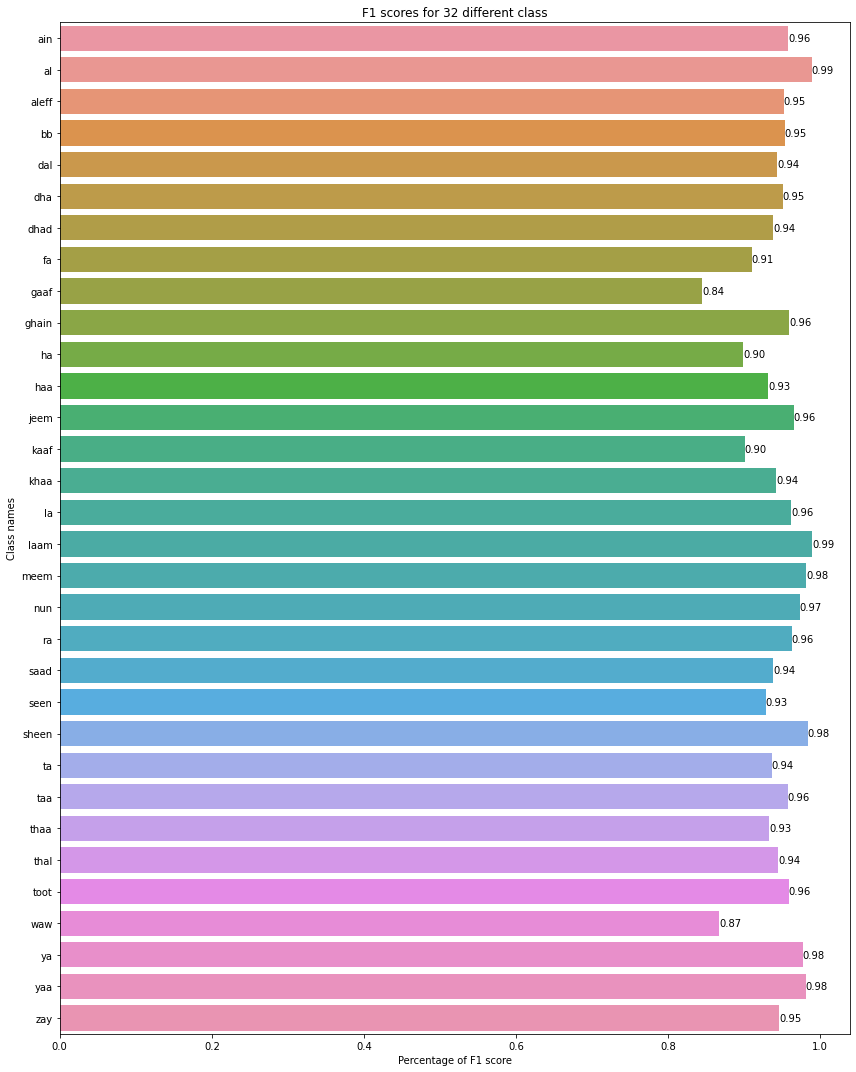

In [ ]:
# Plotting the F1 score
plt.figure(figsize=(12, 15))
ax = sns.barplot(x=list(classes_f1_score.values()), y=list(classes_f1_score.keys()), data=pd.DataFrame({"class_names": classes_f1_score.keys(), "F1-score": classes_f1_score.values()}))
ax.bar_label(ax.containers[0], fmt="%.2f")
plt.title("F1 scores for 32 different class")
plt.xlabel("Percentage of F1 score")
plt.ylabel("Class names")
plt.tight_layout()

### Testing Video classification with TensorFlow model

In [ ]:
arabic_letters_map = {"aleff": "ا",
                      "bb": "ب",
                      "taa": "ت",
                      "thaa": "ث",
                      "jeem": "ج",
                      "haa": "ح",
                      "khaa": "خ",
                      "dal": "د",
                      "thal": "ذ",
                      "ra": "ر",
                      "zay": "ز",
                      "seen": "س",
                      "sheen": "ش",
                      "saad": "ص",
                      "dhad": "ض",
                      "ta": "ط",
                      "dha": "ظ",
                      "ain": "ع",
                      "ghain": "غ",
                      "fa": "ف",
                      "gaaf": "ق",
                      "kaaf": "ك",
                      "laam": "ل",
                      "meem": "م",
                      "nun": "ن",
                      "ha": "ه",
                      "waw": "و",
                      "ya": "ئ",
                      "toot": "ة",
                      "al": "ال",
                      "la": "لا",
                      "yaa": "ي"}

In [ ]:
def check_rotation(path_video_file):
    """
    A Function to check the oreintation of the video we want to read and process.

    Required to run: installing `ffmpeg-python` from pip,
    Install it using `pip install ffmpeg-python`

    Args:
    path_video_file - A string that indicate the relative path to video in your folder.

    Returns:
    A Correct oreintation of video.
    """
    # this returns meta-data of the video file in form of a dictionary
    meta_dict = ffmpeg.probe(path_video_file)

    # from the dictionary, meta_dict['streams'][0]['tags']['rotate'] is the key
    # we are looking for
    rotateCode = None
    try:
        current_rotation = int(meta_dict['streams'][0]['tags']['rotate'])
        if  current_rotation == 90:
            # rotateCode = cv2.ROTATE_90_CLOCKWISE
            rotateCode = cv2.ROTATE_180
        elif current_rotation == 180:
            # rotateCode = cv2.ROTATE_180
            rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE
        elif current_rotation == 270:
            rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE
    except:
        return rotateCode

    return rotateCode

In [ ]:
def correct_rotation(frame, rotateCode):
    """
    A Helper function to get the correct oreintation of video file.

    Args:
    frame - A single image from video which parsed frame by frame by another function.
    rotateCode - A rotation of type `int` for video.

    Returns:
    A Rotated frame in the correct direction.
    """
    return cv2.rotate(frame, rotateCode)

In [ ]:
def vod_classify(video_path, model, class_names):
    """
    A Function to Classify a video of Arabic sign language for each sign will be prompted in the upper right of the video.
    Later those signs gestures will be translated into a more readable way using another helper function to read.

    P.S: Classes names right now in the form as the authors written it.

    Args:
    video_path - A relative path to the video.
    model - the model you want to classify the video with.
    class_names - a list of class names (the same form of structure the dataset subfolders.)

    Returns:
    A list of classes to map later into a more readable way.
    """
    # Reading the video from path
    vod = cv2.VideoCapture(video_path)

    # initialize writer var for writing on desk 
    writer = None

    # Deque for Prediction flickering problem
    all_preds = deque(maxlen=64)

    # The classified classes to translate later on.
    classified_classes = []

    # check if video requires rotation
    rotateCode = check_rotation(video_path)

    while True:
        # Read the video object.
        ret_flag, frame = vod.read()

        # if frame in vod broken stop loop or reached the end of it.
        if not ret_flag:
            break
        
        # check if the frame needs to be rotated
        if rotateCode is not None:
            frame = correct_rotation(frame, rotateCode)

        # Grab the Width & Height of frame
        H, W = frame.shape[:2]

        # Prepare Conversion of frame
        new_frame = frame.copy()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (64, 64)).astype("float32") 

        # Make predictions
        frame_norm = frame/255.
        probs = model_2.predict(np.expand_dims(frame_norm, axis=0))[0]
        
        # Perform Rolling Averaging for predictions
        all_preds.append(probs)
        y_preds = np.array(all_preds).mean(axis=0)
        y_preds = np.argmax(y_preds)
        # print(y_preds)
        label = class_names[y_preds]

        # Add the classified class for Concatination later
        classified_classes.append(label)

        # Prepare the Label
        text = f"Sign Detected: {label}"
        cv2.putText(new_frame, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX,
            1.5, (238, 255, 0), 3)
        
        # Create classified video
        if writer is None:
            writer = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*"MJPG"), 25, (W,H))
        
        writer.write(new_frame)

    writer.release()
    vod.release()
    return classified_classes

In [ ]:
classified_classes = vod_classify(video_path="/content/20220905_193254.mp4",
                                  model=model_2,
                                  class_names=class_names)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
# _, f = cv2.VideoCapture("/content/20220905_180537.mp4").read()
# print(f.shape)
# gray = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY).astype("float32")
# print(gray.dtype)
# # gray = cv2.rotate(gray, cv2.ROTATE_180)
# cv2_imshow(gray)

In [ ]:
def map_words(letter_list, arabic_dict, arabic_mapping=arabic_letters_map):
    possible_words = letter_list
    sent = ""
    letter_check = ""
    correct_words = []

    for letter in possible_words:
        letter = arabic_mapping[letter]
        if letter_check == letter:
            # Reset letter holder
            letter_check = letter
            # Skip for conflicted letters
            continue
        # Concat the new letter
        sent+= letter

        # Check if new formed letters really a word ?
        if sent in arabic_dict:
            correct_words.append(sent)
            sent = ""
        # Reset letter for holder
        letter_check = letter

    return " ".join(correct_words)

In [ ]:
map_words(classified_classes,
          np.array(df["Words"]),
          arabic_letters_map)

'م ظ و ة ذ م ظ ة ظ ي ا'

## Creating Third CNN Model

### Undersamping

In [ ]:
num_samples = []
for dirpath, dirnames, filenames in os.walk("/content/ArASL_Database_54K_Final"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
    if len(filenames) != 0:
        num_samples.append(len(filenames))

target_size = np.min(num_samples)

def under_sample(path_imgs, target_size):
    path = path_imgs #
    n_target = target_size # 1307
    folder_list = os.listdir(path) 
    for folders in folder_list:
        folder_path = os.path.join(path, folders)
        print(folder_path)
        img_names = os.listdir(folder_path)  
        img_nums = len(img_names) - n_target 
        img_names = random.sample(img_names, img_nums)
        for image in img_names:  
            f = os.path.join(folder_path, image)
            os.remove(f) 

under_sample("/content/ArASL_Database_54K_Final",
             target_size=target_size)

There are 32 directories and 0 images in /content/ArASL_Database_54K_Final
There are 0 directories and 1507 images in /content/ArASL_Database_54K_Final/sheen
There are 0 directories and 1293 images in /content/ArASL_Database_54K_Final/yaa
There are 0 directories and 1607 images in /content/ArASL_Database_54K_Final/khaa
There are 0 directories and 1832 images in /content/ArASL_Database_54K_Final/laam
There are 0 directories and 1816 images in /content/ArASL_Database_54K_Final/ta
There are 0 directories and 1582 images in /content/ArASL_Database_54K_Final/thal
There are 0 directories and 1670 images in /content/ArASL_Database_54K_Final/dhad
There are 0 directories and 1895 images in /content/ArASL_Database_54K_Final/saad
There are 0 directories and 1791 images in /content/ArASL_Database_54K_Final/toot
There are 0 directories and 1526 images in /content/ArASL_Database_54K_Final/haa
There are 0 directories and 1774 images in /content/ArASL_Database_54K_Final/kaaf
There are 0 directories an

In [ ]:
for dirpath, dirnames, filenames in os.walk("/content/ArASL_Database_54K_Splitted"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 3 directories and 0 images in /content/ArASL_Database_54K_Splitted
There are 32 directories and 0 images in /content/ArASL_Database_54K_Splitted/test
There are 0 directories and 260 images in /content/ArASL_Database_54K_Splitted/test/sheen
There are 0 directories and 260 images in /content/ArASL_Database_54K_Splitted/test/yaa
There are 0 directories and 260 images in /content/ArASL_Database_54K_Splitted/test/khaa
There are 0 directories and 260 images in /content/ArASL_Database_54K_Splitted/test/laam
There are 0 directories and 260 images in /content/ArASL_Database_54K_Splitted/test/ta
There are 0 directories and 260 images in /content/ArASL_Database_54K_Splitted/test/thal
There are 0 directories and 260 images in /content/ArASL_Database_54K_Splitted/test/dhad
There are 0 directories and 260 images in /content/ArASL_Database_54K_Splitted/test/saad
There are 0 directories and 260 images in /content/ArASL_Database_54K_Splitted/test/toot
There are 0 directories and 260 images in

### Splitting the dataset into train/val/test sets

The ratio=(0.6, 0.2, 0.2)

In [ ]:
# Splitting the files into train/val/test
splitfolders.ratio('/content/ArASL_Database_54K_Final', output="ArASL_Database_54K_Splitted", seed=1337, ratio=(0.6, 0.2, 0.2))

Copying files: 54049 files [00:07, 7540.97 files/s]


### Creating 3rd CNN Model

In [ ]:
TRAIN_DIR = "/content/ArASL_Database_54K_Splitted/train"
VAL_DIR = "/content/ArASL_Database_54K_Splitted/val"
TEST_DIR = "/content/ArASL_Database_54K_Splitted/test"
IMAGE_SIZE = 64

train_gen = ImageDataGenerator(rescale=1/255.,
                               shear_range=0.1,
                               zoom_range=0.1,
                               width_shift_range=0.2,
	                           height_shift_range=0.2,
                               brightness_range=(0.1, 0.4))

val_gen = ImageDataGenerator(rescale=1/255.)

test_gen = ImageDataGenerator(rescale=1/255.)

train_data = train_gen.flow_from_directory(directory=TRAIN_DIR,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           batch_size=16,
                                           class_mode="sparse",
                                           color_mode="rgb",
                                           shuffle=True,
                                           seed=1337)

val_data = val_gen.flow_from_directory(directory=VAL_DIR,
                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                       batch_size=16,
                                       class_mode="sparse",
                                       color_mode="rgb",
                                       shuffle=False,
                                       seed=1337)

test_data = test_gen.flow_from_directory(directory=TEST_DIR,
                                         target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                         shuffle=False,
                                         batch_size=16,
                                         class_mode="sparse",
                                         color_mode="rgb",
                                         seed=1337)


IMAGE_SHAPE = (64, 64, 3)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, activation="relu", input_shape=IMAGE_SHAPE),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(32, activation="softmax")
], name="Model_3")

model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["sparse_categorical_accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=3,
                                              restore_best_weights=True)

model_3.summary()

Found 32417 images belonging to 32 classes.
Found 10797 images belonging to 32 classes.
Found 10835 images belonging to 32 classes.
Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       7385

#### Train 3rd CNN Model

In [ ]:
hist_3 = model_3.fit(train_data,
                    epochs=500,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data),
                    callbacks=[early_stop])

Epoch 1/500
1550/1550 [==============================] - 76s 48ms/step - loss: 3.4658 - sparse_categorical_accuracy: 0.0311 - val_loss: 3.4655 - val_sparse_categorical_accuracy: 0.0334
Epoch 2/500
1550/1550 [==============================] - 58s 37ms/step - loss: 2.6233 - sparse_categorical_accuracy: 0.2373 - val_loss: 2.1027 - val_sparse_categorical_accuracy: 0.5528
Epoch 3/500
1550/1550 [==============================] - 57s 37ms/step - loss: 1.0880 - sparse_categorical_accuracy: 0.6626 - val_loss: 1.1323 - val_sparse_categorical_accuracy: 0.7269
Epoch 4/500
1550/1550 [==============================] - 56s 36ms/step - loss: 0.7391 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.8580 - val_sparse_categorical_accuracy: 0.8356
Epoch 5/500
1550/1550 [==============================] - 56s 36ms/step - loss: 0.5750 - sparse_categorical_accuracy: 0.8236 - val_loss: 0.5980 - val_sparse_categorical_accuracy: 0.8686
Epoch 6/500
1550/1550 [==============================] - 56s 36ms/step - lo

#### Evaluate 3rd model on Test data

In [ ]:
model_3.evaluate(test_data)

520/520 [==============================] - 7s 13ms/step - loss: 0.2279 - sparse_categorical_accuracy: 0.9632


[0.227935791015625, 0.9632211327552795]

In [ ]:
model_3.save("Arabic-sign-language-translation-CNN-3RD-EDITON.h5")

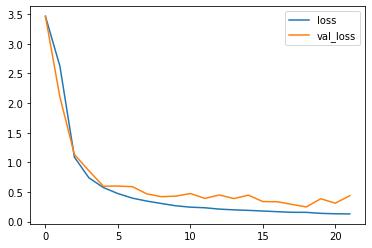

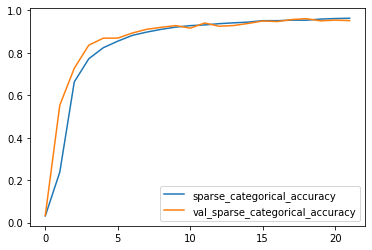

In [ ]:
preds_3 = pd.DataFrame(hist_3.history)
preds_3[["loss", "val_loss"]].plot()
preds_3[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()

##### Test the saved model

In [ ]:
model_3_test = tf.keras.models.load_model("/content/drive/MyDrive/Arabic-sign-language-translation-CNN-3RD-EDITON.h5")
model_3_test.evaluate(test_data)

520/520 [==============================] - 5s 10ms/step - loss: 0.2279 - sparse_categorical_accuracy: 0.9632


[0.227935791015625, 0.9632211327552795]

### Plotting Confusion Matrix

In [ ]:
model_3 = tf.keras.models.load_model("/content/drive/MyDrive/Arabic-sign-language-translation-CNN-3RD-EDITON")

In [ ]:
probs = model_3.predict(test_data)
y_preds = probs.argmax(axis=1)
y_preds

array([ 0,  0,  0, ..., 31, 31, 31])

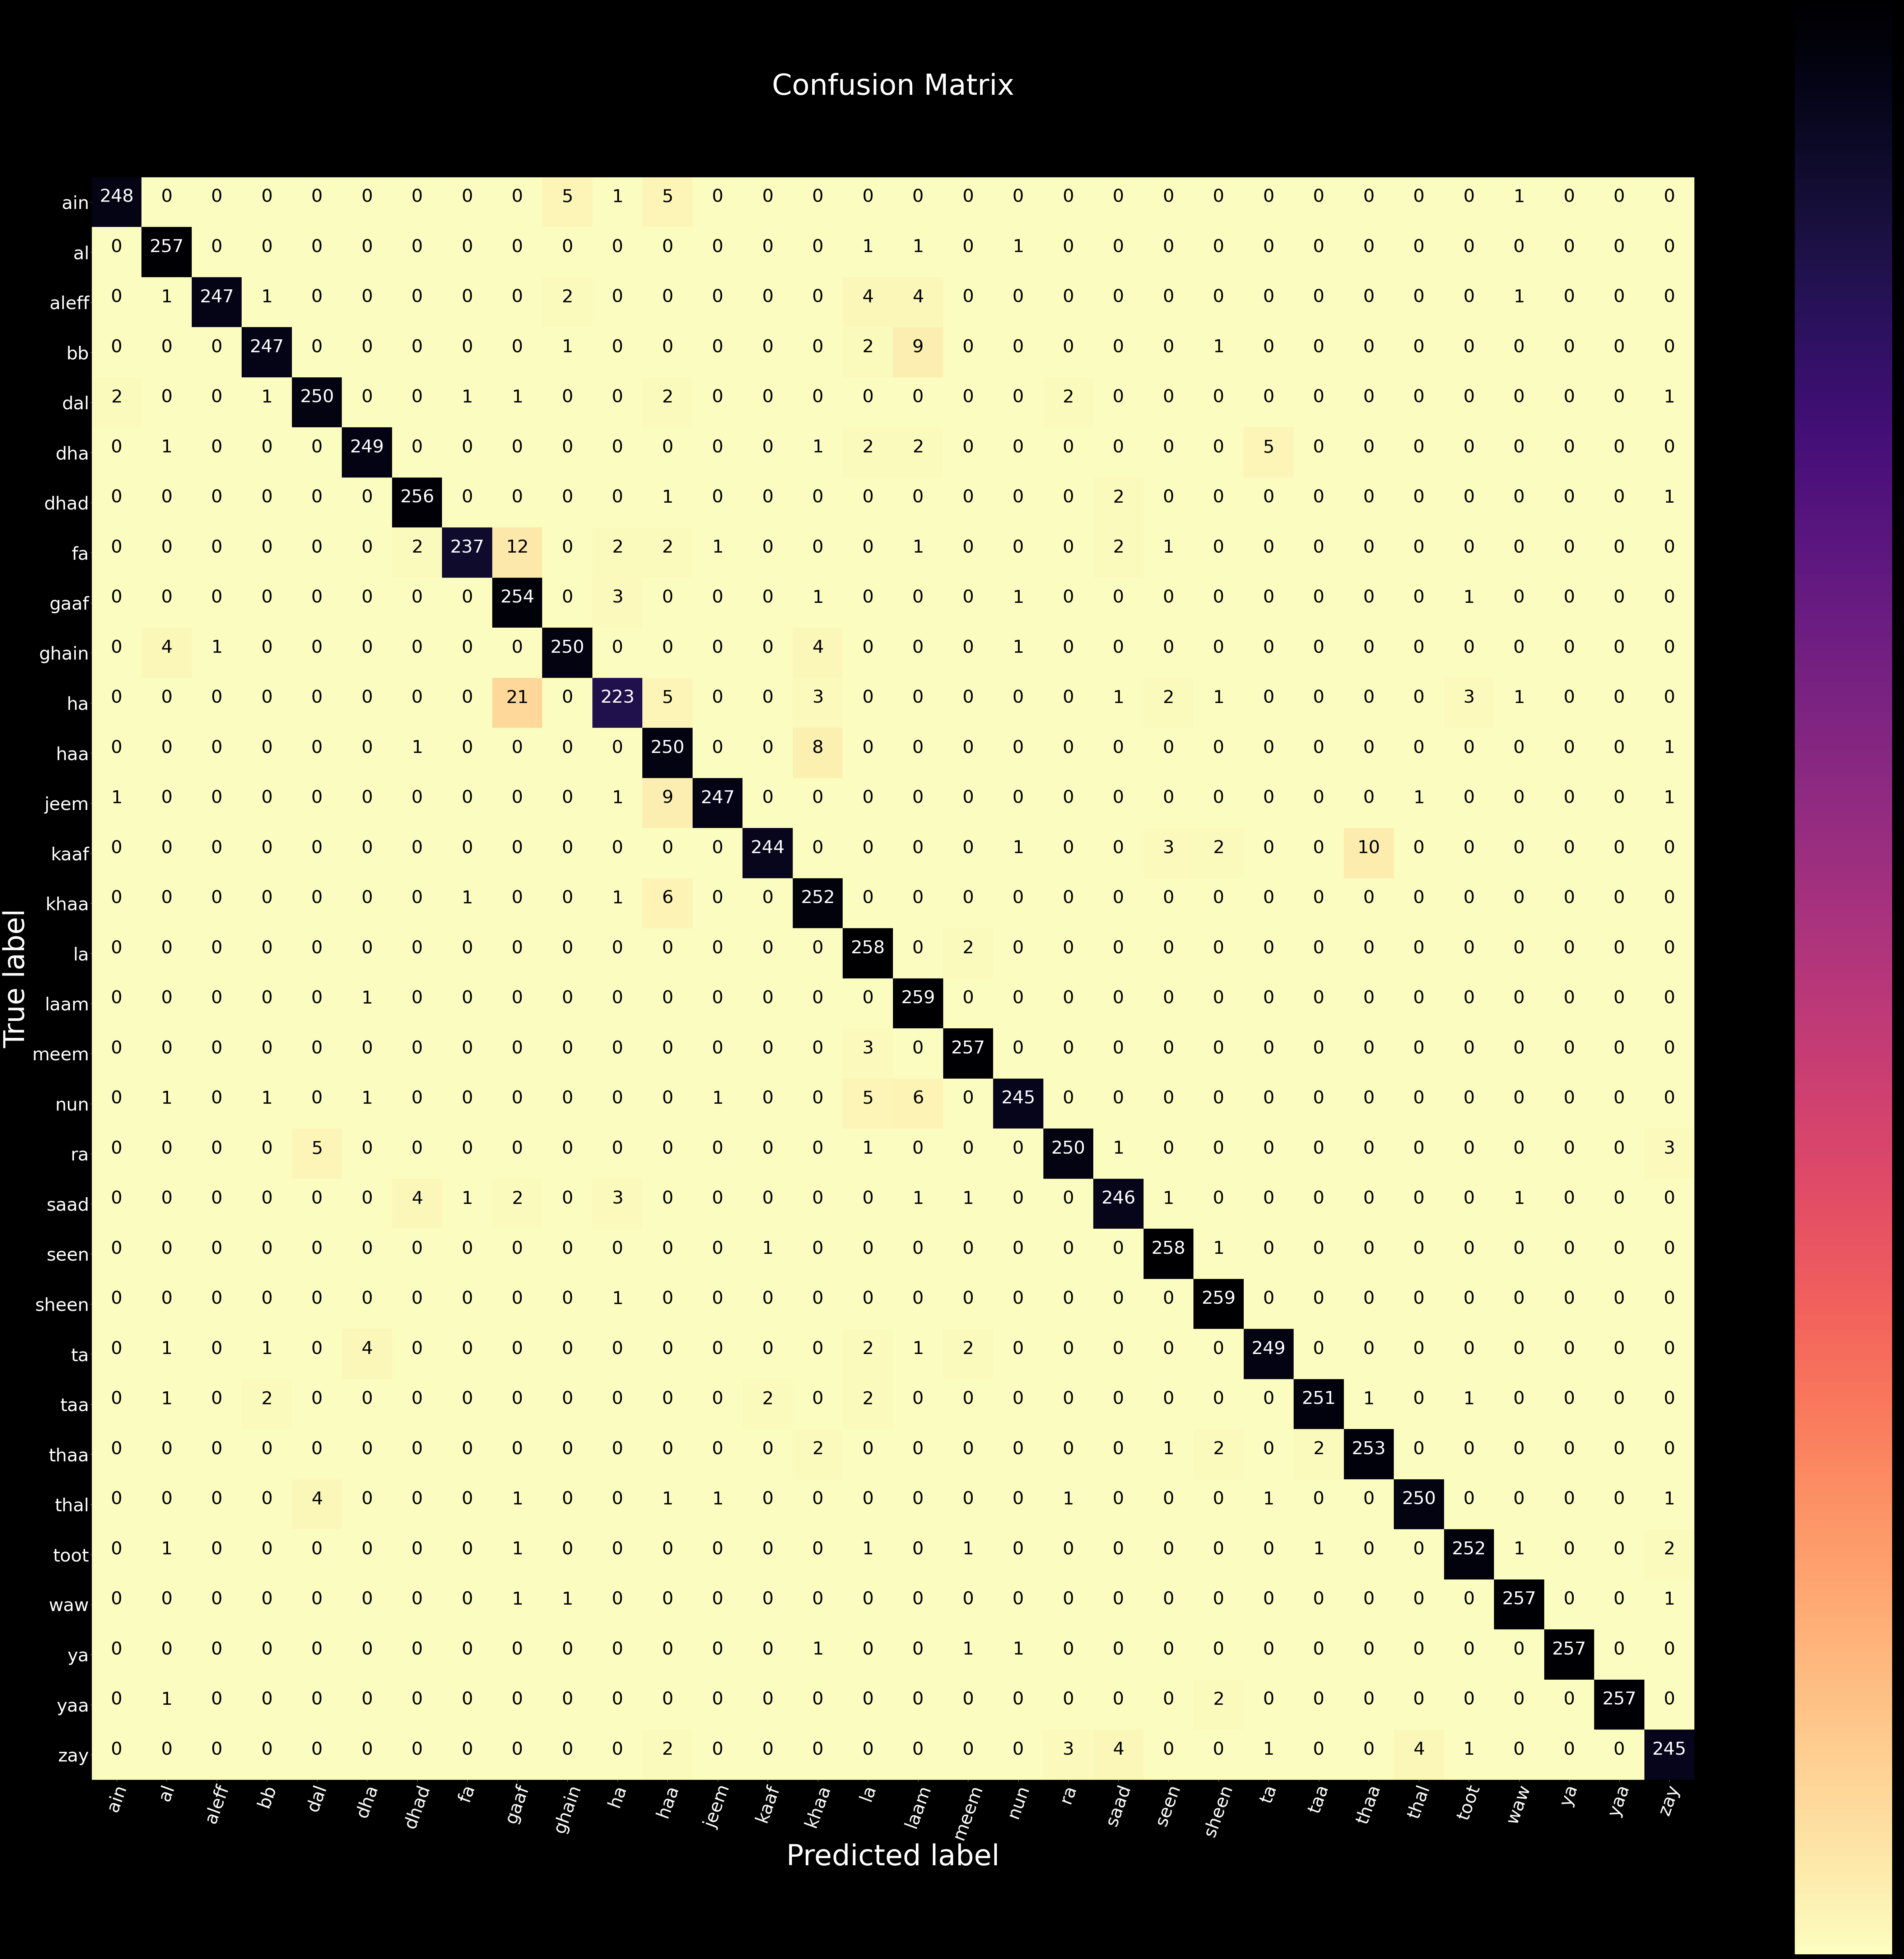

In [ ]:
# Plot a confusion matrix
make_confusion_matrix(y_true=test_data.classes,
                      y_pred=y_preds,
                      figsize=(100, 100),
                      classes=class_names,
                      text_size=50,
                      norm=False)

### Plotting F1 scores

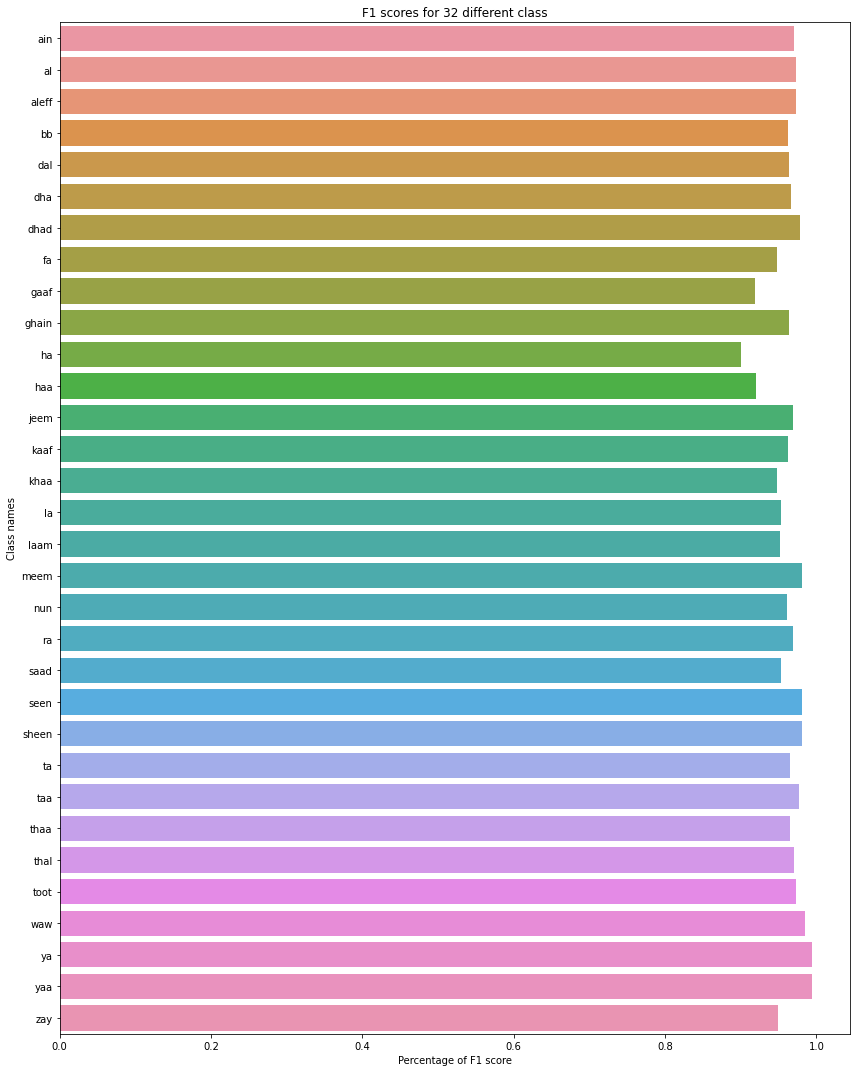

In [ ]:
# Prepare dictionary for F1 scores
from sklearn.metrics import classification_report
classification_dictionary = classification_report(test_data.classes, y_preds, output_dict=True)
classes_f1_score = {}

for k, v in classification_dictionary.items():
    if k == "accuracy":
        break
    classes_f1_score[class_names[int(k)]] = v["f1-score"]

# Plotting the F1 score
plt.figure(figsize=(12, 15))
ax = sns.barplot(x=list(classes_f1_score.values()), y=list(classes_f1_score.keys()), data=pd.DataFrame({"class_names": classes_f1_score.keys(), "F1-score": classes_f1_score.values()}))
# ax.bar_label(ax.containers[0], fmt="%.2f")
plt.title("F1 scores for 32 different class")
plt.xlabel("Percentage of F1 score")
plt.ylabel("Class names")
plt.tight_layout()

In [ ]:
classes_f1_score

{'ain': 0.9706457925636008,
 'al': 0.9734848484848485,
 'aleff': 0.9724409448818898,
 'bb': 0.962962962962963,
 'dal': 0.9633911368015414,
 'dha': 0.9669902912621359,
 'dhad': 0.9789674952198854,
 'fa': 0.948,
 'gaaf': 0.9186256781193489,
 'ghain': 0.9633911368015414,
 'ha': 0.901010101010101,
 'haa': 0.9208103130755064,
 'jeem': 0.9686274509803922,
 'kaaf': 0.9625246548323471,
 'khaa': 0.9473684210526316,
 'la': 0.9537892791127542,
 'laam': 0.9522058823529411,
 'meem': 0.9809160305343512,
 'nun': 0.9607843137254902,
 'ra': 0.9689922480620154,
 'saad': 0.9534883720930233,
 'seen': 0.9809885931558935,
 'sheen': 0.9810606060606061,
 'ta': 0.9651162790697675,
 'taa': 0.9766536964980544,
 'thaa': 0.9656488549618321,
 'thal': 0.970873786407767,
 'toot': 0.9729729729729729,
 'waw': 0.9846743295019158,
 'ya': 0.9941972920696325,
 'yaa': 0.9941972920696325,
 'zay': 0.9496124031007752}

In [ ]:
class_names = sorted(os.listdir(TEST_DIR))

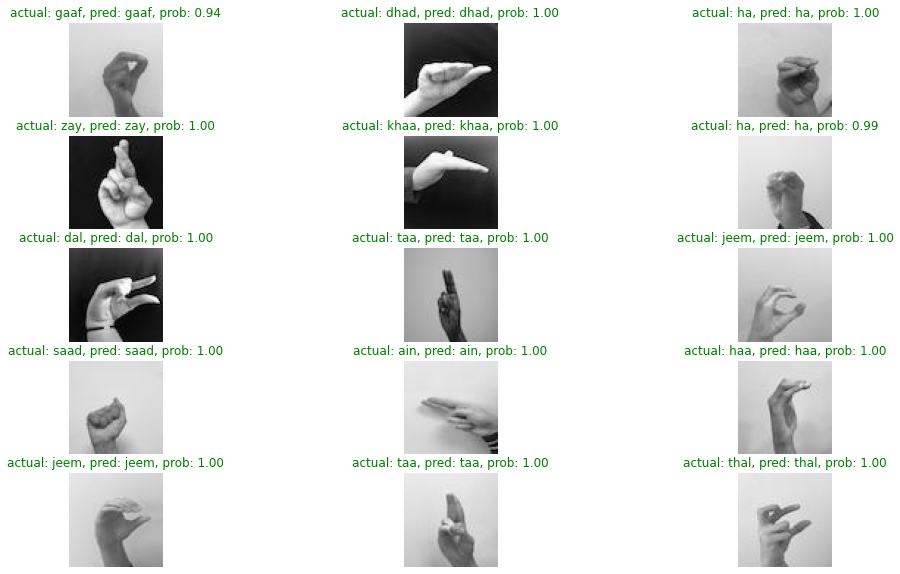

In [ ]:
plt.figure(figsize=(17, 10))
for i in range(15):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(TEST_DIR + "/" + class_name))
  filepath = TEST_DIR + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = prepare_image(filepath) 
  pred_prob = model_3.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
  plt.subplot(5, 3, i+1)
  plt.imshow(img)
  if class_name == pred_class: 
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);